In [44]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re 
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

from sklearn.utils import shuffle

In [45]:
os.getcwd()
pd.set_option('display.max_columns', 100)

In [46]:
#download data for genuine users

df_gen_users = pd.read_csv('datasets_full.csv/genuine_accounts.csv/users.csv')

#define columns to keep for investigation

columns_to_keep = ['id', 'name', 'screen_name', 'statuses_count', 'followers_count',
       'friends_count', 'favourites_count', 'listed_count', 'url', 'lang',
       'time_zone', 'location', 'default_profile', 'default_profile_image',
       'geo_enabled', 'profile_image_url', 'profile_banner_url',
       'profile_use_background_image', 'profile_background_image_url_https',
       'profile_text_color', 'profile_image_url_https','follow_request_sent', 
       'verified','description', 'following']

# trim the bot data and add a binary column = 1 to indicate that this data is human data

df_gen_users = df_gen_users[columns_to_keep]
df_gen_users['bot'] = 0

In [47]:
#features from tweet data
columns_to_keep_t = ['retweet_count','favorite_count','num_hashtags','num_urls','num_mentions']

In [48]:
#combining with tweet data
df_gen_tweets = pd.read_csv('datasets_full.csv/genuine_accounts.csv/tweets.csv')
temp = df_gen_tweets.groupby("user_id").mean()
temp = temp[columns_to_keep_t]
df_gen_user_mix = pd.merge(df_gen_users, temp, how = 'left',left_on='id', right_on='user_id')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [49]:
# download data for traditional bots for training purpose
# use trad_bot_1 since it was the main focus of the 'traditional model'

df_trad_bot1_users = pd.read_csv('datasets_full.csv/traditional_spambots_1.csv/users.csv')

# trim the bot data and add a binary column = 1 to indicate that this data is bot data
df_trad_bot1_users = df_trad_bot1_users[columns_to_keep]
df_trad_bot1_users['bot'] = 1

In [50]:
#combining with tweet data
df_trad_bot1_tweets = pd.read_csv('datasets_full.csv/traditional_spambots_1.csv/tweets.csv')
temp = df_trad_bot1_tweets.groupby("user_id").mean()
temp = temp[columns_to_keep_t]
df_trad_bot1_mix = pd.merge(df_trad_bot1_users, temp, how = 'left',left_on='id', right_on='user_id')

In [51]:
# calling results of sentiment analysis
df_gen_sentiment = pd.read_csv('datasets_full.csv/sentiments/df_gen_tweets_sentiments.csv')
df_trad_bot1_sentiment = pd.read_csv('datasets_full.csv/sentiments/df_trad_bot1_tweets_sentiments_spare.csv')
df_test_bot3_sentiment = pd.read_csv('datasets_full.csv/sentiments/df_bot3_tweets_sentiments.csv')
df_gen_sentiment_user=df_gen_sentiment.groupby("user_id").mean()
df_trad_bot1_sentiment_user=df_trad_bot1_sentiment.groupby("user_id").mean()
df_test_bot3_sentiment_user=df_test_bot3_sentiment.groupby("user_id").mean()

In [52]:
# combine sentiment data and split the genuine data into training set and test set to avoid overlap
df_gen_user_mix = pd.merge(df_gen_user_mix, df_gen_sentiment_user, how = 'left',left_on='id', right_on='user_id')
df_trad_bot1_mix = pd.merge(df_trad_bot1_mix, df_trad_bot1_sentiment_user, how = 'left',left_on='id', right_on='user_id')

df_gen_train, df_gen_test = train_test_split(df_gen_user_mix, test_size = 0.5, shuffle = True)

In [53]:
#create training dataset by concatenating the training split of genuine data and trad_bot_1 data
df_train = pd.concat([df_gen_train.sample(len(df_trad_bot1_mix)), df_trad_bot1_mix])
df_train = shuffle(df_train)

In [54]:
# Create the test set
# Use social spambots #3 as the separate test data set (social spambots #1 contain Italian tweets and cannot be used for sentiment analysis)

df_test_bot3_users = pd.read_csv('datasets_full.csv/social_spambots_3.csv/users.csv')
df_test_bot3_users = df_test_bot3_users[columns_to_keep]
df_test_bot3_users['bot'] = 1

#combining with tweet data
df_test_bot3_tweets = pd.read_csv('datasets_full.csv/social_spambots_3.csv/tweets.csv')
temp2 = df_test_bot3_tweets.groupby("user_id").mean()
temp2 = temp2[columns_to_keep_t]
df_test_bot3_mix = pd.merge(df_test_bot3_users, temp2, how = 'left',left_on='id', right_on='user_id')
df_test_bot3_mix = pd.merge(df_test_bot3_mix, df_test_bot3_sentiment_user, how = 'left',left_on='id', right_on='user_id')

#create test set with 50% genuine data, and 50% social spambot data
df_test_3 = pd.concat([df_gen_test.sample(len(df_test_bot3_mix)), df_test_bot3_mix])
df_test_3 = shuffle(df_test_3)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [55]:
#define data cleaning functions

#cleaning step 1: check if screen_name has a word 'bot' in it

def screen_name_check (df):
    
    word = 'bot'
    bot_name = []
    k = 0

    for i in range (len(df)):
        if pd.isnull(df.iloc[i,:]['screen_name']):
                k = 0
        else: 
            if word in df.iloc[i,:]['screen_name']:
                k = 1
            else:
                k = 0
        bot_name.append(k)
    
    return bot_name


#cleaning step 2: check if location parameter is present

def location_check(df):
    
    loc = []

    for i in range (len(df)):
        if pd.isnull(df.iloc[i,:]['location']):
            loc.append(0)
        else:
            loc.append(1)
            
    return loc

# cleaning step 3
# Set description to 1 if it contains either of these words: 
#‘bot’, ‘robot’, ‘artificial’, ‘intelligence’, ‘neural’, ‘network’, ‘automatic’ and 0 otherwise.

def description_check(df):
    keyword = ['bot', 'robot', 'artificial', 'intelligence', 'neural', 'network', 'automatic']
    bot_des = []
    k = 0

    for i in range (len(df)):
        for keyword in keyword:
            if pd.isnull(df.iloc[i,:]['description']):
                k = 0
            else:
                if df.iloc[i,:]['description'].find(keyword) == -1:
                    k = 0
                else:
                    k = 1
        bot_des.append(k)
        
    return bot_des

#cleaning step 4:
#Set verified to 1 if the sample’s verified features contents are True and 0 otherwise.

def verified_check(df):
    ver = []

    for i in range (len(df)):
        if pd.isnull(df.iloc[i,:]['verified']):
            ver.append(0)
        else:
            ver.append(1)
    return ver

#cleaning step 5:
#Check if default profile exists or not.

def default_profile_check (df):
    
    default_profile = []

    for i in range (len(df)):
        if pd.isnull(df.iloc[i,:]['default_profile']):
            default_profile.append(0)
        else:
            default_profile.append(1)
    
    return default_profile

#cleaning step 6:
#Check if default profile image is used or not.

def default_image_check (df):
    
    default_profile_image = []

    for i in range (len(df)):
        if pd.isnull(df.iloc[i,:]['default_profile_image']):
            default_profile_image.append(0)
        else:
            default_profile_image.append(1)
    
    return default_profile_image

In [56]:
def master_clean (df):
    bot_name = screen_name_check (df)
    loc = location_check (df)
    bot_des = description_check (df)
    ver = verified_check (df)
    default_profile = default_profile_check (df)
    default_profile_image = default_image_check (df)
    
    df = pd.DataFrame({'screen_name': df['screen_name'],
                       'name': df['name'],
                       'bot_in_name':bot_name,
                       'bot_in_des':bot_des,
                       'location': loc,
                       'verified': ver,
                       'default_profile': default_profile,
                       'default_profile_image': default_profile_image,
                       'followers_count': df['followers_count'],
                       'listed_count': df['listed_count'],
                       'friends_count': df['friends_count'],
                       'favourites_count': df['favourites_count'],
                       'statuses_count': df['statuses_count'],
                       'retweet_count_mean':df['retweet_count'],
                       'favorite_count_mean':df['favorite_count'],
                       'num_hashtags_mean':df['num_hashtags'],
                       'num_urls_mean':df['num_urls'],
                       'num_mentions_mean':df['num_mentions'],
                       'polarity':df['polarity'],
                       'subjectivity':df['subjectivity'],
                       'bot_or_not':df['bot']
                       })
    
    return df

In [57]:
#apply the cleaning function to training set and testing set
df_train = master_clean(df_train)
df_test_3 = master_clean(df_test_3)

In [58]:
#add a feature of missingness
def add_missingness(df):
    inds = np.where(df.isnull())
    inds = np.array(inds).tolist()
    inds
    inds_list = []
    for i in inds[0]:
        if i not in inds_list:
            inds_list.append(i)
    df["Missingness"] = 0
    for i in inds_list:
        df.iloc[i,-1] = 1
    return df

In [59]:
df_train_2=add_missingness(df_train)
df_test_3_2=add_missingness(df_test_3)

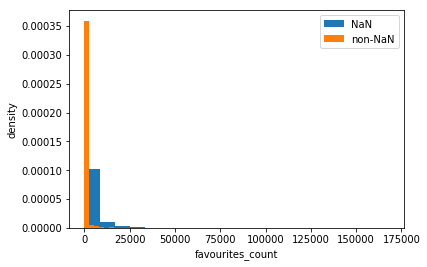

In [76]:
#checking bias of missingness
plt.hist(df_train_2.favourites_count[df_train_2.Missingness==1],bins=20,label='NaN',density=True)
plt.hist(df_train_2.favourites_count[df_train_2.Missingness==0],bins=20,label='non-NaN',density=True)
plt.legend()
plt.xlabel("favourites_count")
plt.ylabel("density");

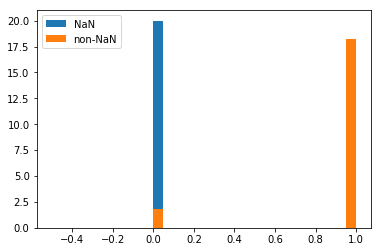

In [66]:
plt.hist(df_train_2.bot_or_not[df_train_2.Missingness==1],bins=20,label='NaN',density=True)
plt.hist(df_train_2.bot_or_not[df_train_2.Missingness==0],bins=20,label='non-NaN',density=True)
plt.legend()

In [77]:
# index of rows which contain NaN
inds = np.where(df_train_2.isna())
inds = np.array(inds).tolist()
inds_list = []
for i in inds[0]:
    if i not in inds_list:
        inds_list.append(i)

In [78]:
#prepare for imputation
columns_to_keep_nan = ['retweet_count_mean', 'favorite_count_mean', 'num_hashtags_mean', 'num_urls_mean', 'num_mentions_mean', 'polarity','subjectivity']

In [79]:
#linear regression imputation
from sklearn.linear_model import LinearRegression

def linear_imputation(df,columns_withna):
    df2=df.copy()
    df3=df.copy()
    df2=df2.drop(columns=["screen_name","name"])
    df_dropna=df2.dropna()
    for feature in columns_withna:
        x_set = df_dropna[df_dropna.columns.difference(columns_withna)]
        y_set = df_dropna[feature]
        
        linear_reg = LinearRegression()
        linear_reg.fit(x_set,y_set)
        ytest_hat = linear_reg.predict(df2[df2.columns.difference(columns_withna)])
        df3[feature]=ytest_hat
    df3.update(df)
    return df3

In [80]:
df_train_3 = linear_imputation(df_train_2, columns_to_keep_nan)
df_test_3_3 = linear_imputation(df_test_3_2, columns_to_keep_nan)

In [81]:
print(df_train_3.shape)
display(df_train_3.head())
print(df_test_3_3.shape)
display(df_test_3_3.head())

(2000, 22)


,screen_name,name,bot_in_name,bot_in_des,location,verified,default_profile,default_profile_image,followers_count,listed_count,friends_count,favourites_count,statuses_count,retweet_count_mean,favorite_count_mean,num_hashtags_mean,num_urls_mean,num_mentions_mean,polarity,subjectivity,bot_or_not,Missingness
2861,nic_thebrit,Nicole,0,0,1,0,0,0,1285,10,586,1255,25362,723.604156,0.199390,0.281984,0.148255,0.838666,0.079159,0.270335,0,1
638,scloneski_vip,' \u03dfFuck-Uk,0,0,0,0,0,0,510,0,1338,1,152,0.000000,0.000000,0.000000,0.644737,0.019737,0.164439,0.188297,1,0
2857,nestorflecha,Néstor Flecha,0,1,1,0,0,0,11617,89,815,862,12033,800.318039,0.664446,0.297004,0.113244,1.042411,0.097596,0.300916,0,1
37,frankly_scarlet,Weight Loss Advice,0,0,0,0,0,0,2782,34,2063,0,806,0.000000,0.000000,0.000000,0.997519,0.000000,0.108748,0.319755,1,0
429,Elizabeth99xa,Elizabeth,0,0,0,0,0,0,47,1,203,0,1,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.066667,1,0


(928, 22)


,screen_name,name,bot_in_name,bot_in_des,location,verified,default_profile,default_profile_image,followers_count,listed_count,friends_count,favourites_count,statuses_count,retweet_count_mean,favorite_count_mean,num_hashtags_mean,num_urls_mean,num_mentions_mean,polarity,subjectivity,bot_or_not,Missingness
372,Cuthillvibe,Krystina Cuthill,0,0,0,0,1,0,1308,7,926,1,12725,0.010157,0.014466,0.000000,0.473992,0.000000,0.180576,0.366099,1,1
3227,suggnite,kt got bandz,0,0,1,0,0,0,170,0,174,2292,3258,778.808660,0.304069,0.374590,0.143861,0.853546,0.090164,0.300368,0,1
1999,crxwnxfthxrns,Minnie,0,1,1,0,0,0,777,8,88,3836,102429,-55.540521,-0.009621,0.186847,0.226841,0.800216,0.059558,0.276441,0,1
335,Wolleydig,Elin Wolley,0,0,0,0,1,0,1203,9,975,0,11313,0.007769,0.036358,0.000000,0.459602,0.000000,0.181080,0.366572,1,1
1300,Seabazzking707,Colombian Mamba,0,0,0,0,0,0,145,0,109,1484,1304,755.641151,0.276059,0.010718,0.108846,0.645887,0.128214,0.332279,0,1


In [82]:
#########
#Model by dropping NaN

In [83]:
df_train_dn = df_train.dropna()
print(df_train_dn.shape)
display(df_train_dn.head())
df_test_3_dn = df_test_3.dropna()
print(df_test_3_dn.shape)
display(df_test_3_dn.head())

(1097, 22)


,screen_name,name,bot_in_name,bot_in_des,location,verified,default_profile,default_profile_image,followers_count,listed_count,friends_count,favourites_count,statuses_count,retweet_count_mean,favorite_count_mean,num_hashtags_mean,num_urls_mean,num_mentions_mean,polarity,subjectivity,bot_or_not,Missingness
638,scloneski_vip,' \u03dfFuck-Uk,0,0,0,0,0,0,510,0,1338,1,152,0.0,0.0,0.000000,0.644737,0.019737,0.164439,0.188297,1,0
37,frankly_scarlet,Weight Loss Advice,0,0,0,0,0,0,2782,34,2063,0,806,0.0,0.0,0.000000,0.997519,0.000000,0.108748,0.319755,1,0
429,Elizabeth99xa,Elizabeth,0,0,0,0,0,0,47,1,203,0,1,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.066667,1,0
679,FUCKYUNGBERG,FUCKYUNGBERG,0,0,0,0,0,0,227,1,1413,0,256,0.0,0.0,0.003906,0.910156,0.292969,0.114763,0.176900,1,0
949,laio_araujo,laio araujo,0,0,1,0,0,0,798,2,1847,2,50,0.0,0.0,0.280000,0.400000,0.160000,0.018667,0.031333,1,0


(381, 22)


,screen_name,name,bot_in_name,bot_in_des,location,verified,default_profile,default_profile_image,followers_count,listed_count,friends_count,favourites_count,statuses_count,retweet_count_mean,favorite_count_mean,num_hashtags_mean,num_urls_mean,num_mentions_mean,polarity,subjectivity,bot_or_not,Missingness
1856,blue_raven,Ange,0,1,1,0,0,0,332,45,833,1862,59052,34.080000,0.138769,0.036000,0.009538,0.559077,0.061415,0.347669,0,0
53,safariiguide,Safari iGuide,0,1,0,0,0,0,931,7,1369,0,11088,0.006830,0.013350,0.000000,0.456380,0.000000,0.179567,0.366387,1,0
3408,xenanimous,Xena Joyce,0,1,1,0,0,0,1243,3,777,52,5340,778.340945,0.233657,0.044729,0.030028,1.058805,0.062540,0.214486,0,0
98,ILOVEMONOPOLY,I Love Monopoly,0,1,0,0,0,0,905,9,1940,1,12461,0.005234,0.013547,0.000000,0.463362,0.000000,0.189263,0.370571,1,0
118,ilovejohnnya,Johnny Adams,0,1,0,0,0,0,925,3,1569,1,12111,0.005578,0.012395,0.000000,0.464208,0.000000,0.185093,0.364978,1,0


In [84]:
#Prepare dataset to feed into the model

# X_train from df_train
X_train = df_train_3.drop(columns=['bot_or_not', 'screen_name', 'name'])
X_train_dn = df_train_dn.drop(columns=['bot_or_not', 'screen_name', 'name'])

# y_trian from df_train
y_train = df_train_3[['bot_or_not']]
y_train_dn = df_train_dn[['bot_or_not']]

# X_test_3 from df_test_3
X_test_3 = df_test_3_3.drop(columns=['bot_or_not', 'screen_name', 'name'])
X_test_dn = df_test_3_dn.drop(columns=['bot_or_not', 'screen_name', 'name'])

# y_test_3 from df_test_3
y_test_3 = df_test_3_3[['bot_or_not']]
y_test_dn = df_test_3_dn[['bot_or_not']]

In [85]:
# standardize dataset

def standardize (df,df_train):
    con_var = ['followers_count', 'listed_count', 'friends_count', 'favourites_count', 'statuses_count',
               'retweet_count_mean','favorite_count_mean','num_hashtags_mean','num_urls_mean','num_mentions_mean',
              'polarity','subjectivity']

    for var in con_var:
        x = df[var]
        x = (x - x.mean())/x.std()
        df[var] = x
    
    return df

X_train_norm = standardize(X_train,X_train)
X_test_3_norm = standardize(X_test_3,X_train)
X_train_norm_dn = standardize(X_train_dn,X_train_dn)
X_test_3_norm_dn = standardize(X_test_dn,X_train_dn)

In [86]:
# Simple Decision Tree with linear imputation

decision_model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=3)
decision_model.fit(X_train, y_train)

y_pred_train_dec = decision_model.predict(X_train_norm)
y_pred_test_3_dec = decision_model.predict(X_test_3_norm)

train_score_dec = accuracy_score(y_train, y_pred_train_dec) * 100
test_score_3_dec = accuracy_score(y_test_3, y_pred_test_3_dec) * 100

print('accuracy score of the training set is {}%'.format(train_score_dec))
print('accuracy score of the test set with social spambot #3 is {}%'.format(test_score_3_dec))

accuracy score of the training set is 100.0%
accuracy score of the test set with social spambot #3 is 49.137931034482754%


In [87]:
# Simple Decision Tree with dropna

decision_model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=3)
decision_model.fit(X_train_dn, y_train_dn)

y_pred_train_dec = decision_model.predict(X_train_norm_dn)
y_pred_test_3_dec = decision_model.predict(X_test_3_norm_dn)

train_score_dec = accuracy_score(y_train_dn, y_pred_train_dec) * 100
test_score_3_dec = accuracy_score(y_test_dn, y_pred_test_3_dec) * 100

print('accuracy score of the training set is {}%'.format(train_score_dec))
print('accuracy score of the test set with social spambot #3 is {}%'.format(test_score_3_dec))

accuracy score of the training set is 100.0%
accuracy score of the test set with social spambot #3 is 93.7007874015748%


In [88]:
depth = np.arange(2,30,1)
decision_score_mean=[]
decision_score_std=[]
test_1_score = []
test_3_score = []

for i in depth:
    decision_model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=i)
    decision_model.fit(X_train_norm, y_train)
    score = cross_val_score(estimator = decision_model, X = X_train_norm, y = y_train, cv = 5)
    decision_score_mean.append(score.mean())
    decision_score_std.append(score.std())
    test_3_score.append(accuracy_score(y_test_3, decision_model.predict(X_test_3_norm)))

Text(0,0.5,'test set accuracy score')

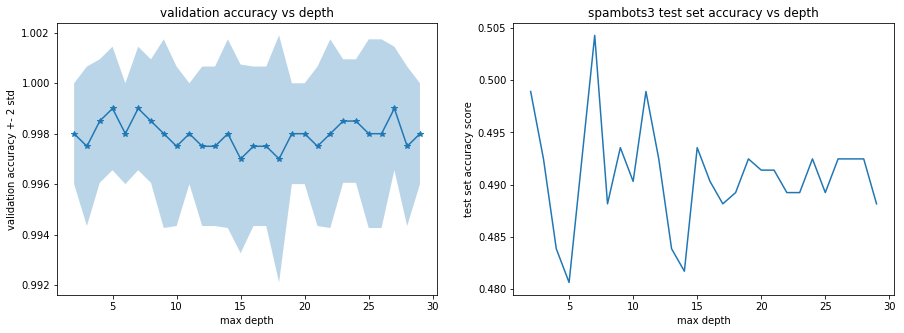

In [89]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

ax[0].plot(depth, decision_score_mean, '-*')
ax[0].fill_between(
    depth,
    np.array(decision_score_mean) - 2 * np.array(decision_score_std),
    np.array(decision_score_mean) + 2 * np.array(decision_score_std),
    alpha=.3)
ax[0].set_title('validation accuracy vs depth')
ax[0].set_xlabel('max depth')
ax[0].set_ylabel('validation accuracy +- 2 std')

ax[1].plot(depth, test_3_score)
ax[1].set_title('spambots3 test set accuracy vs depth')
ax[1].set_xlabel('max depth')
ax[1].set_ylabel('test set accuracy score')

In [91]:
depth = np.arange(2,30,1)
decision_score_mean=[]
decision_score_std=[]
test_1_score = []
test_3_score = []

for i in depth:
    decision_model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=i)
    decision_model.fit(X_train_norm_dn, y_train_dn)
    score = cross_val_score(estimator = decision_model, X = X_train_norm_dn, y = y_train_dn, cv = 5)
    decision_score_mean.append(score.mean())
    decision_score_std.append(score.std())
    test_3_score.append(accuracy_score(y_test_dn, decision_model.predict(X_test_3_norm_dn)))

Text(0,0.5,'test set accuracy score')

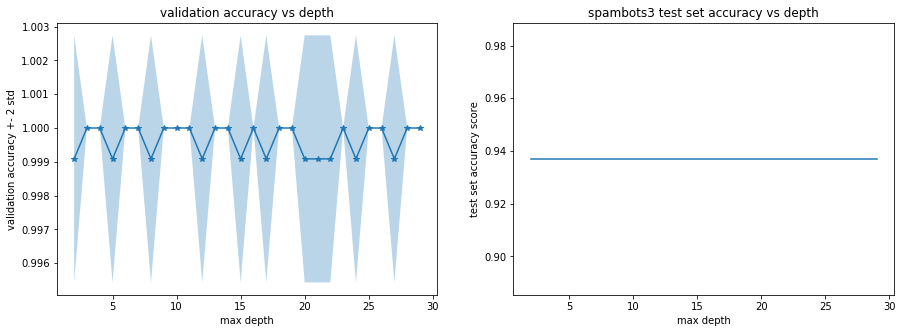

In [92]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

ax[0].plot(depth, decision_score_mean, '-*')
ax[0].fill_between(
    depth,
    np.array(decision_score_mean) - 2 * np.array(decision_score_std),
    np.array(decision_score_mean) + 2 * np.array(decision_score_std),
    alpha=.3)
ax[0].set_title('validation accuracy vs depth')
ax[0].set_xlabel('max depth')
ax[0].set_ylabel('validation accuracy +- 2 std')

ax[1].plot(depth, test_3_score)
ax[1].set_title('spambots3 test set accuracy vs depth')
ax[1].set_xlabel('max depth')
ax[1].set_ylabel('test set accuracy score')

In [30]:
# bagging with linear imputation
overfit_depth = 100
N = 100

bagging_model = BaggingClassifier(DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=overfit_depth), 
                                  n_estimators = N, bootstrap = True, oob_score = True)
bagging_model.fit(X_train_norm, y_train)

y_pred_train_bag = bagging_model.predict(X_train_norm)
y_pred_test_3_bag = bagging_model.predict(X_test_3_norm)

train_score_bag = accuracy_score(y_train, y_pred_train_bag) * 100
test_score_3_bag = accuracy_score(y_test_3, y_pred_test_3_bag) * 100

print('accuracy score of the training set is {}%'.format(train_score_bag))
print('accuracy score of the test set with social spambot #3 is {}%'.format(test_score_3_bag))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy score of the training set is 100.0%
accuracy score of the test set with social spambot #3 is 94.07327586206897%


In [31]:
# bagging with dropna
overfit_depth = 100
N = 100

bagging_model = BaggingClassifier(DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=overfit_depth), 
                                  n_estimators = N, bootstrap = True, oob_score = True)
bagging_model.fit(X_train_norm_dn, y_train_dn)

y_pred_train_bag = bagging_model.predict(X_train_norm_dn)
y_pred_test_3_bag = bagging_model.predict(X_test_3_norm_dn)

train_score_bag = accuracy_score(y_train_dn, y_pred_train_bag) * 100
test_score_3_bag = accuracy_score(y_test_dn, y_pred_test_3_bag) * 100

print('accuracy score of the training set is {}%'.format(train_score_bag))
print('accuracy score of the test set with social spambot #3 is {}%'.format(test_score_3_bag))

accuracy score of the training set is 100.0%
accuracy score of the test set with social spambot #3 is 95.07772020725389%


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [32]:
#ada boosting with linear imputation
ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),  
                               n_estimators=800, learning_rate=0.05)

ada_model.fit(X_train_norm, y_train)

y_pred_train_ada = ada_model.predict(X_train_norm)
y_pred_test_3_ada = ada_model.predict(X_test_3_norm)

train_score_ada = accuracy_score(y_train, y_pred_train_ada) * 100
test_score_3_ada = accuracy_score(y_test_3, y_pred_test_3_ada) * 100

print('accuracy score of the training set is {}%'.format(train_score_ada))
print('accuracy score of the test set with social spambot #3 is {}%'.format(test_score_3_ada))

accuracy score of the training set is 100.0%
accuracy score of the test set with social spambot #3 is 82.4353448275862%


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [33]:
#ada boosting with dropna
ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),  
                               n_estimators=800, learning_rate=0.05)

ada_model.fit(X_train_norm_dn, y_train_dn)

y_pred_train_ada = ada_model.predict(X_train_norm_dn)
y_pred_test_3_ada = ada_model.predict(X_test_3_norm_dn)

train_score_ada = accuracy_score(y_train_dn, y_pred_train_ada) * 100
test_score_3_ada = accuracy_score(y_test_dn, y_pred_test_3_ada) * 100

print('accuracy score of the training set is {}%'.format(train_score_ada))
print('accuracy score of the test set with social spambot #3 is {}%'.format(test_score_3_ada))

accuracy score of the training set is 100.0%
accuracy score of the test set with social spambot #3 is 95.07772020725389%


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
#Random Forests with linear imputation
overfit_depth = 100
N = 100

rf_model = RandomForestClassifier(n_estimators = N, criterion='gini', 
                                  max_features='auto', max_depth = overfit_depth, bootstrap=True,
                                 oob_score=True)
rf_model.fit(X_train_norm, y_train)

y_pred_train = rf_model.predict(X_train_norm)
y_pred_test_3 = rf_model.predict(X_test_3_norm)

train_score = accuracy_score(y_train, y_pred_train) * 100
test_score_3 = accuracy_score(y_test_3, y_pred_test_3) * 100

oobs_score = rf_model.oob_score_

print('accuracy score of the training set is {}%'.format(train_score))
print('accuracy score of the test set with social spambot #3 is {}%'.format(test_score_3))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


accuracy score of the training set is 100.0%
accuracy score of the test set with social spambot #3 is 83.1896551724138%


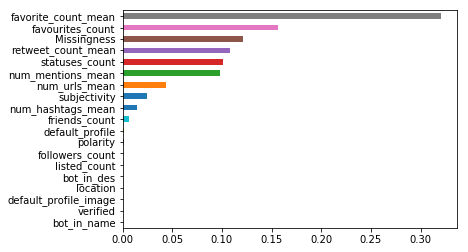

In [35]:
#showing significant features
pd.Series(rf_model.feature_importances_,index=list(X_train_norm)).sort_values().plot(kind="barh")

In [36]:
#Random Forests with dropna
overfit_depth = 100
N = 100

rf_model = RandomForestClassifier(n_estimators = N, criterion='gini', 
                                  max_features='auto', max_depth = overfit_depth, bootstrap=True,
                                 oob_score=True)
rf_model.fit(X_train_norm_dn, y_train_dn)

y_pred_train = rf_model.predict(X_train_norm_dn)
y_pred_test_3 = rf_model.predict(X_test_3_norm_dn)

train_score = accuracy_score(y_train_dn, y_pred_train) * 100
test_score_3 = accuracy_score(y_test_dn, y_pred_test_3) * 100

oobs_score = rf_model.oob_score_

print('accuracy score of the training set is {}%'.format(train_score))
print('accuracy score of the test set with social spambot #3 is {}%'.format(test_score_3))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


accuracy score of the training set is 100.0%
accuracy score of the test set with social spambot #3 is 96.6321243523316%


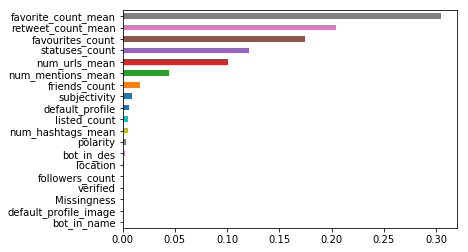

In [37]:
#showing significant features
pd.Series(rf_model.feature_importances_,index=list(X_train_norm_dn)).sort_values().plot(kind="barh")

In [38]:
# Multinominal Logistic Regression with linear imputation

log_model = LogisticRegressionCV(fit_intercept=True, cv=5, multi_class="ovr", penalty='l2', max_iter=10000)
log_model.fit(X_train, y_train.values.reshape(-1))

y_pred_train_log = log_model.predict(X_train_norm)
y_pred_test_3_log = log_model.predict(X_test_3_norm)

train_score_log = accuracy_score(y_train, y_pred_train_log) * 100
test_score_3_log = accuracy_score(y_test_3, y_pred_test_3_log) * 100

print('accuracy score of the training set is {}%'.format(train_score_log))
print('accuracy score of the test set with social spambot #3 is {}%'.format(test_score_3_log))

accuracy score of the training set is 99.95%
accuracy score of the test set with social spambot #3 is 95.6896551724138%


In [39]:
# Multinominal Logistic Regression with dropna

log_model = LogisticRegressionCV(fit_intercept=True, cv=5, multi_class="ovr", penalty='l2', max_iter=10000)
log_model.fit(X_train_dn, y_train_dn.values.reshape(-1))

y_pred_train_log = log_model.predict(X_train_norm_dn)
y_pred_test_3_log = log_model.predict(X_test_3_norm_dn)

train_score_log = accuracy_score(y_train_dn, y_pred_train_log) * 100
test_score_3_log = accuracy_score(y_test_dn, y_pred_test_3_log) * 100

print('accuracy score of the training set is {}%'.format(train_score_log))
print('accuracy score of the test set with social spambot #3 is {}%'.format(test_score_3_log))

accuracy score of the training set is 100.0%
accuracy score of the test set with social spambot #3 is 95.59585492227978%


Text(0,0.5,'Mean Accuracy Score')

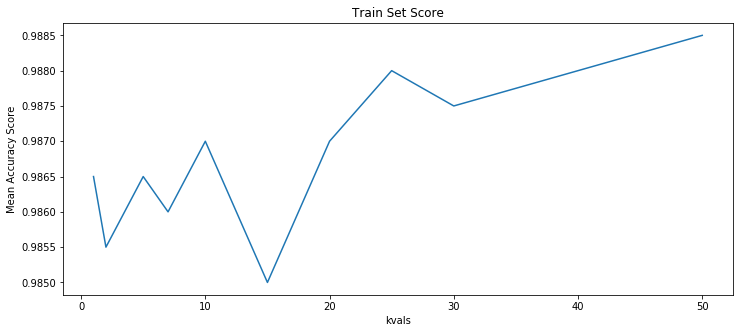

In [40]:
#kNN  with linear imputation
kvals = [1, 2, 5, 7, 10, 15, 20, 25, 30, 50]
knn_score_train = []

for i in kvals:
    model_knn = KNeighborsClassifier(n_neighbors=i, weights = 'uniform')
    train_score = cross_val_score(model_knn, X = X_train_norm, y = y_train.values.reshape(-1), cv=5)
    knn_score_train.append(train_score.mean())

fig, ax = plt.subplots(1,1, figsize = (12,5))

ax.plot(kvals, knn_score_train)
ax.set_title("Train Set Score")
ax.set_xlabel("kvals")
ax.set_ylabel("Mean Accuracy Score")

In [41]:
knn_model = KNeighborsClassifier(n_neighbors=10,weights = 'uniform')
knn_model.fit(X_train, y_train.values.reshape(-1))

y_pred_train_knn = knn_model.predict(X_train)
y_pred_test_3_knn = knn_model.predict(X_test_3)

train_score_knn = accuracy_score(y_train, y_pred_train_knn) * 100
test_score_3_knn = accuracy_score(y_test_3, y_pred_test_3_knn) * 100

print('accuracy score of the training set is {}%'.format(train_score_log))
print('accuracy score of the test set with social spambot #3 is {}%'.format(test_score_3_knn))

accuracy score of the training set is 100.0%
accuracy score of the test set with social spambot #3 is 92.88793103448276%


Text(0,0.5,'Mean Accuracy Score')

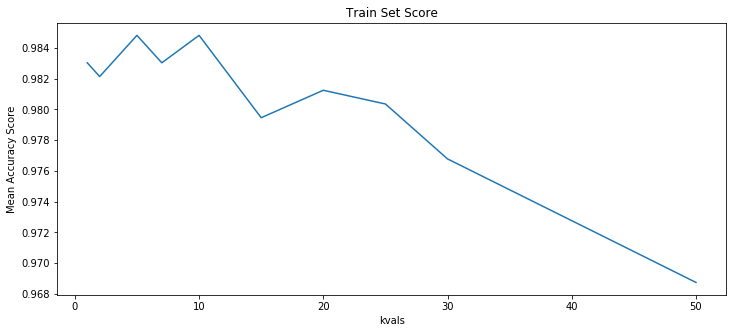

In [42]:
#kNN  with dropna
kvals = [1, 2, 5, 7, 10, 15, 20, 25, 30, 50]
knn_score_train = []

for i in kvals:
    model_knn = KNeighborsClassifier(n_neighbors=i, weights = 'uniform')
    train_score = cross_val_score(model_knn, X = X_train_norm_dn, y = y_train_dn.values.reshape(-1), cv=5)
    knn_score_train.append(train_score.mean())

fig, ax = plt.subplots(1,1, figsize = (12,5))

ax.plot(kvals, knn_score_train)
ax.set_title("Train Set Score")
ax.set_xlabel("kvals")
ax.set_ylabel("Mean Accuracy Score")

In [43]:
knn_model = KNeighborsClassifier(n_neighbors=10,weights = 'uniform')
knn_model.fit(X_train_dn, y_train_dn.values.reshape(-1))

y_pred_train_knn = knn_model.predict(X_train_norm_dn)
y_pred_test_3_knn = knn_model.predict(X_test_3_norm_dn)

train_score_knn = accuracy_score(y_train_dn, y_pred_train_knn) * 100
test_score_3_knn = accuracy_score(y_test_dn, y_pred_test_3_knn) * 100

print('accuracy score of the training set is {}%'.format(train_score_log))
print('accuracy score of the test set with social spambot #3 is {}%'.format(test_score_3_knn))

accuracy score of the training set is 100.0%
accuracy score of the test set with social spambot #3 is 91.19170984455958%
